<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Quantum State Tomography*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Christopher J. Wood$^{1}$ and Jay M. Gambetta$^{1}$

1. IBM T.J. Watson Research Center, Yorktown Heights, NY, USA

## Introduction

In this notebook we demonstrate how to design and run experiments to perform quantum state tomography using QISKit, and demonstrate this using both simulators, and the IBM Quantum Experience. 

The functions used in this notebook to implement state tomography may be imported from the `tools.tomography` module.

#### Experiment Design

The tomography experiments demonstrated in this notebook append a state preparation circuit with to perform measurements of all qubits in each of the X, Y, and Z Pauli bases. For $n$-qubits this gives a total of $3^n$ measurement circuits which must be run, and the resulting counts for the $6^n$ measurement outcomes accross all circuits give a tomographically overcomplete basis for reconstruction of the quantum state.

#### State Reconstruction Methods

State reconstruction may be done using a variety of methods. In this notebook implement two simple cases, they are: 
* Linear Inversion
* Fast maximum likelihood (*see [J Smolin, JM Gambetta, G Smith, Phys. Rev. Lett. 108, 070502](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.070502), open access: [arXiv:1106.5458](https://arxiv.org/abs/1106.5458)*).

In [1]:
# Checking the version of PYTHON; we only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
import numpy as np
    
# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# import tomography libary
import qiskit.tools.qcvv.tomography as tomo

# useful additional packages 
from qiskit.tools.visualization import plot_state, plot_histogram
from qiskit.tools.qi.qi import state_fidelity, concurrence, purity, outer

## State tomography of an entangled Bell-state

We will demonstrate preparation, measurement, and tomographic reconstruction of a 2-qubit Bell state $\frac{1}{\sqrt2}\left(|00\rangle+|11\rangle\right)$.

### State preparation

We begin with constructing a circuit to prepare the target state, this circuit requires a 2-qubit quantum register, and a 2-bit classical register to store measurement outcomes.

In [2]:
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config['url']) # set the APIToken and API url

# Creating registers
qr = Q_program.create_quantum_register('qr', 2)
cr = Q_program.create_classical_register('cr', 2)

# quantum circuit to make an entangled bell state 
bell = Q_program.create_circuit('bell', [qr], [cr])
bell.h(qr[0])
bell.cx(qr[0], qr[1])

#### Visualization of the ideal state

Before we perform tomographic measurement, lets visualize the ideal output state from the preparation circuit. We may do this by executing the circuit on the `local_qasm_simulator` backend. Since this is a simulation, it gives us direct access to the final state vector if we only perform a single shot.

In [3]:
bell_result = Q_program.execute(['bell'], backend='local_qasm_simulator', shots=1)
bell_psi = bell_result.get_data('bell')['quantum_state']
bell_rho = outer(bell_psi) # construct the density matrix from the state vector

We may visualize the final state using the `plot_state` function. This can either return a *city plot*, which is a 2D-bar plot of real and imaginary matrix elements of a density matrix $\rho$.

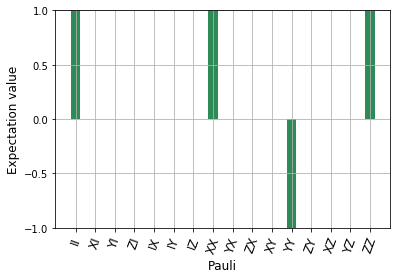

In [4]:
# plot the state
plot_state(bell_rho,'paulivec')

We can compare the ideal entangled state to a non-entangled mixed state $\frac{1}{2}(|00\rangle\langle00| +|11\rangle\langle11|)$:

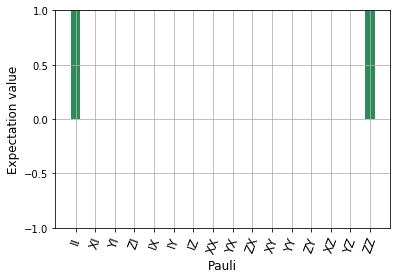

In [5]:
rho_mixed = np.array([[1,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])/2
plot_state(rho_mixed, 'paulivec')

### Building tomography measurement circuits

Next we must construct a family of circuits which implement a tomographically complete set of measurements of the qubit. The **`tools.tomography.py`** module contains functions to generate these measurement circuits for general n-qubit systems. 

#### Specifying the measured qubits and measurement basis

A state tomography experiment is specified by a **`state_tomography_set`** object: 
```python
tomo_set = tomo.state_tomography_set(qubits, meas_basis)
```
where
- `qubits` is a list of the qubit indexes within a register (eg. [0, 1] for the first 2 qubits)
- `meas_basis` is the basis to measure each qubit in. The default value is `meas_basis='Pauli'`.

This contains information about which qubits are to be measured, and in what basis. The default option is to measure each single qubit in the X, Y, and Z bases.  This results in $3^n$ measurement circuits which must be executed to gather count statistics for the tomographic reconstruction.

#### Adding measurement circuits to a Quantum Program

Once a state tomography set has been defined the function to append the tomography circuits to a `QuantumProgram` is:
```python
tomo_labels = tomo.create_tomography_circuits(Q_program, 'name', qr, cr, state_tomo_set)
```
where 
- `Q_program` is the quantum program containing the preparation circuit `'name'`.
- `'name'` is the name of the preparation circuit. 
- `qr` is the quantum register in `Q_program` to be measured.
- `cr` is the classical register in `Q_program` to store the measurement results. 
- `state_tomo_set` is a `state_tomography_set`.

The function output, `tomo_labels`, is a list of the strings for each of the tomography circuit names stored in the `Q_program`, which is used to execute the tomography experiments. The measures qubits will be `qr[j]`, with corresponding measurement outcomes stored in classical bits `cr[j]` where `j` corresponds to each qubit in the state tomography set.

In [6]:
# Construct state tomography set for measurement of qubits [0, 1] in the Pauli basis
bell_tomo_set = tomo.state_tomography_set([0, 1])

# Add the state tomography measurement circuits to the Quantum Program
bell_tomo_circuits = tomo.create_tomography_circuits(Q_program, 'bell', qr, cr, bell_tomo_set)
print('Created State tomography circuit labels:')
for c in bell_tomo_circuits:
    print(c)

Created State tomography circuit labels:
bell_meas_X(0)X(1)
bell_meas_X(0)Y(1)
bell_meas_X(0)Z(1)
bell_meas_Y(0)X(1)
bell_meas_Y(0)Y(1)
bell_meas_Y(0)Z(1)
bell_meas_Z(0)X(1)
bell_meas_Z(0)Y(1)
bell_meas_Z(0)Z(1)


### Testing experiments on a simulator

Now that we have prepared the required circuits for state preparation and measurement, we should test them on a simulator before trying to run them on the real device.

We specify the device, and a number of experiment shots to perform to gather measurement statistics. The larger the number of shots, the more accurate our measurmeent probabilities will be compared to the *true* value.

In [7]:
# Use the local simulator
backend = 'local_qasm_simulator'

# Take 5000 shots for each measurement basis
shots = 5000

# Run the simulation
bell_tomo_result = Q_program.execute(bell_tomo_circuits, backend=backend, shots=shots)
print(bell_tomo_result)

COMPLETED


### Extracting tomography data from results

Next we extract the tomography data from the output results using:
```python
data = tomo.tomography_data(results, 'name', state_tomo_set)
```
where
- `results` is the Result object returned from execution of `state_tomo_set` circuits.
- `name` is the name of the original circuit used to generate tomography data
- `state_tomo_set` is the tomography set used for generation of tomography data.

This returns a dictionary which stores the measurement basis, and measured counts along with mesurement basis configuration corresponding to each outcome.

In [8]:
bell_tomo_data = tomo.tomography_data(bell_tomo_result, 'bell', bell_tomo_set)

### Reconstructing state from count data

To reconstruct the maximum likelihod estimate of the measured quantum state we use the following function:
```
tomo.fit_tomography_data(tomo_data, method, options)
```
where
- `QP` is the quantum program containing the measurement results
- `circuits` is the array of tomographic measurement circuits measured
- `shots` is the total number of shots for each measurement circuit
- `total_qubits` is the total number of qubits in the system (the length of shot outcome bitstrings)
- `meas_qubits` is an array of the measurement qubit indices

In [9]:
rho_fit = tomo.fit_tomography_data(bell_tomo_data)

We can compare the reconstructed state to the target state vector. We use the Fidelity function, which for a comparing a density matrix $\rho$ to a pure state $|\psi\rangle$ is given by $F = \sqrt{\langle \psi| \rho |\psi\rangle}$. This may be done by the function **`state_fidelity`** from the **`qiskit.tools.qi`** module.

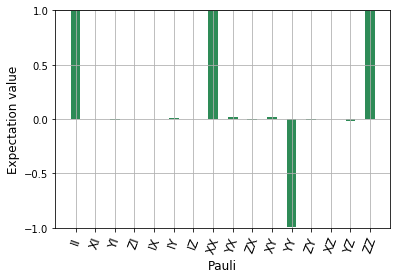

Fidelity = 0.9977073180512603
concurrence =  0.9246572769475115
purity =  0.9911875908887152


In [10]:
# target state is (|00>+|11>)/sqrt(2)
target = np.array([1., 0., 0., 1.]/np.sqrt(2.))

# calculate fidelity, concurrence and purtity of fitted state
F_fit = state_fidelity(rho_fit, [0.707107, 0, 0, 0.707107])
con = concurrence(rho_fit)
pur = purity(rho_fit)

# plot 
plot_state(rho_fit, 'paulivec')
print('Fidelity =', F_fit)
print('concurrence = ', str(con))
print('purity = ', str(pur))

Note that since our simulator is *perfect* the output state should be *exactly* the Bell-state, so we should obtain F = 1. Why is it not in our case? Since we can never directly *see* the final state we must obtain information about it via measurements. We would only obtain the *true* probabilities for the state in the limit of infinite measurement shots. Hence we have statistical error in our reconstruction due to having imperfect information about the state itself. Try running with different number of shots on the simulator and see how it effects the fidelity of the reconstruction.

### Running on a real device

Now that we've checked our simple tomography experiment worked, lets try it out on the IBM Quantum Experience! To do this we must have attached our API key, and it is good practice to set a limit on the number of credits to use:

In [11]:
# Use the IBM Quantum Experience
backend = 'ibmqx2'
# Take 1000 shots for each measurement basis
# Note: reduce this number for larger number of qubits
shots = 1000
# set max credits
max_credits = 8

# Run the simulation
bellqx_tomo_result = Q_program.execute(bell_tomo_circuits, backend=backend, shots=shots,
                           max_credits=max_credits, wait=20, timeout=240)
print(bellqx_tomo_result)

COMPLETED


As before we can extract the tomography data and reconstruct the measured density matrix for the 2-qubit Bell-state prepared by our test circuit

In [12]:
bellqx_tomo_data = tomo.tomography_data(bellqx_tomo_result, 'bell', bell_tomo_set)

# Reconstruct experimentally measured density matrix 
rho_fit_real = tomo.fit_tomography_data(bellqx_tomo_data)

Finally we compare the fidelity of the experimentally measued state to the ideal state. Noticed that the fidelity is lower than for the simulation. This is because in a real experiment there is not only the statistical error in the reconstruction, but also experimental error in the device when implementing the gates in the preparation and measurement circuits, and error in the measurements themselves.

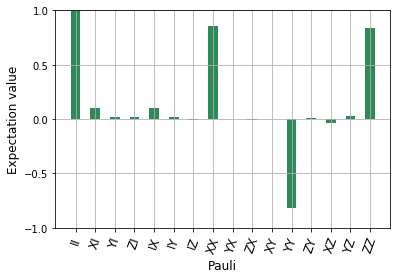

Fidelity with ideal state
F = 0.937599059667
concurrence =  0.63770779981
purity =  0.784084198436


In [13]:
F_fit_real = state_fidelity(rho_fit_real, [0.707107, 0, 0, 0.707107])
plot_state(rho_fit_real, 'paulivec')
print('Fidelity with ideal state')
print('F =', F_fit_real)

# calculate concurrence and purity
con = concurrence(rho_fit_real)
pur = purity(rho_fit_real)
print('concurrence = ', str(con))
print('purity = ', str(pur))

In [1]:
%run "../version.ipynb"

Package,Version
QISKit,0.4.8
IBMQuantumExperience,>= 1.8.26
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"
